# PFN feature analysis

Analyze the high-level features ($\Phi_n$) of the PFN using the SHAP algorithm.

In [1]:
import tensorflow as tf
import numpy as np
import os
from tensorflow import keras
from matplotlib import pyplot as plt

2023-10-28 20:29:28.635803: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
task_name = "axion2"

## 1. Compute high-level features using saved model

In [2]:
# ~1 min
import sys
sys.path.append("../..")

from utils import data_dir, model_dir
from data import get_data

In [4]:
# ~2 min?
(X_train, _, X_test,
 Y_train, _, Y_test) = get_data(task_name)

In [5]:
# 2 sec
model = keras.models.load_model(f"{model_dir}/{task_name}_pfn")

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 960, 4)]          0         
                                                                 
 masking (Masking)           (None, 960, 4)            0         
                                                                 
 Phi_0 (TimeDistributed)     (None, 960, 256)          1280      
                                                                 
 Phi_1 (TimeDistributed)     (None, 960, 256)          65792     
                                                                 
 Phi_2 (TimeDistributed)     (None, 960, 256)          65792     
                                                                 
 Phi_3 (TimeDistributed)     (None, 960, 256)          65792     
                                                                 
 Phi_4 (TimeDistributed)     (None, 960, 128)          32896 

In [6]:
Phi_model = keras.models.Model(inputs=model.input, outputs=model.get_layer("F_0").input)
Phi_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 960, 4)]          0         
                                                                 
 masking (Masking)           (None, 960, 4)            0         
                                                                 
 Phi_0 (TimeDistributed)     (None, 960, 256)          1280      
                                                                 
 Phi_1 (TimeDistributed)     (None, 960, 256)          65792     
                                                                 
 Phi_2 (TimeDistributed)     (None, 960, 256)          65792     
                                                                 
 Phi_3 (TimeDistributed)     (None, 960, 256)          65792     
                                                                 
 Phi_4 (TimeDistributed)     (None, 960, 128)          32896 

In [7]:
F_model = keras.models.Model(inputs=model.get_layer("F_0").input, outputs=model.output)
F_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 F_0 (Dense)                 (None, 256)               33024     
                                                                 
 F_1 (Dense)                 (None, 256)               65792     
                                                                 
 F_2 (Dense)                 (None, 256)               65792     
                                                                 
 F_3 (Dense)                 (None, 256)               65792     
                                                                 
 F_4 (Dense)                 (None, 128)               32896     
                                                                 
 F_5 (Dense)                 (None, 128)               1651

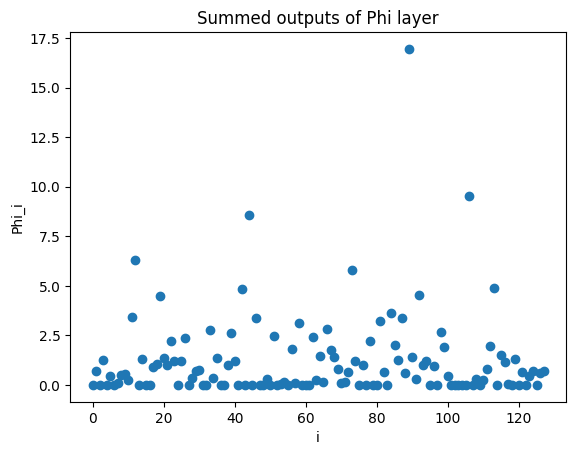

In [8]:
Phi = Phi_model(X_test[0][np.newaxis,...])
plt.xlabel("i")
plt.ylabel("Phi_i")
plt.title("Summed outputs of Phi layer")
plt.scatter(range(len(Phi[0])), Phi[0].numpy());

In [9]:
# Save the outputs of the Phi model
Phi_outputs = Phi_model.predict(X_test)

2023-10-28 19:37:50.038130: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1382400000 exceeds 10% of free system memory.


2813/2813 [==============================] - 142s 50ms/step


In [10]:
print(f"Shape of Phi_outputs:", Phi_outputs.shape)
os.makedirs("Phi_outputs", exist_ok=True)
np.savez(f"./Phi_outputs/{task_name}_Phi_outputs.npz", Phi_outputs)

Shape of Phi_outputs: (90000, 128)


In [11]:
preds = np.argmax(F_model(Phi_outputs), axis=1)
truth = np.argmax(Y_test, axis=1)
print(preds[:10])
print(truth[:10])
print(f"Accuracy: {(preds == truth).sum() / len(preds) * 100:.2f}%")

[0 1 0 2 1 0 1 1 2 1]
[0 1 0 2 1 0 1 1 2 1]
Accuracy: 99.62%


In [12]:
# ~5 sec
F_model.save(f"./{task_name}_F_model")

INFO:tensorflow:Assets written to: ./axion2_F_model/assets


INFO:tensorflow:Assets written to: ./axion2_F_model/assets


# Part 2: Apply SHAP algorithm

https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Multioutput%20Regression%20SHAP.html

In [ ]:
# ~2 min
import shap

In [ ]:
sample_Phi_outputs = shap.sample(Phi_outputs, 50)

In [ ]:
explainer = shap.KernelExplainer(
    model=F_model.predict,
    data=sample_Phi_outputs,
    link="identity"  # Not entirely sure what this does
)

In [ ]:
shap_values = explainer.shap_values(X=sample_Phi_outputs)

In [ ]:
shap.initjs()

In [ ]:
shap.summary_plot(
    shap_values=shap_values[0],
    features=Phi_outputs[:50],
    feature_names=[f"$\Phi_{{{i}}}$" for i in range(Phi_outputs.shape[1])],
    max_display=50
)